In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, LearningCurveDisplay, BaseSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import shap
import numpy as np

In [3]:
data = pd.read_csv('cleaned_linked_data.csv')
print(f"Number of Samples:{data.shape[0]}")
X = data.drop(columns=['ClinicalSignificance','variant_id'])
y = data['ClinicalSignificance']

Number of Samples:63592


In [4]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=42)

{'Benign': 0, 'Pathogenic': 1}


In [15]:
num_pos = sum(y_train)
num_neg = len(y_train) - num_pos
scale_pos_weight = num_neg / num_pos

print(f"Calculated scale_pos_weight: {scale_pos_weight}")
print(f"Train set Positive:{num_pos}, Negative: {num_neg}")

print(f"Globl Test set Positive:{sum(y_encoded)}, Negative: {len(y_encoded)-sum(y_encoded)}")

Calculated scale_pos_weight: 0.2502580486606046
Train set Positive:40690, Negative: 10183
Globl Test set Positive:50863, Negative: 12729


In [6]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = { 'learning_rate': [0.01, 0.1, 0.3],
               'max_depth': [3, 5, 7],
               'min_child_weight': [1, 3, 5],
               'subsample': [0.6, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.8, 1.0],
               
               'scale_pos_weight': [scale_pos_weight]}

In [7]:
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1) 
grid_search.fit(X_train, y_train) # Print the best parameters and best score 
print(f"Best Parameters: {grid_search.best_params_}") 
print(f"Best Score: {grid_search.best_score_:.2f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\demen.SNEAKBOI\PycharmProjects\FinalProject_CAP5610\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'scale_pos_weight': 0.2502580486606046, 'subsample': 1.0}
Best Score: 0.99


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_learning_rate', 'param_max_depth',
       'param_min_child_weight', 'param_scale_pos_weight', 'param_subsample',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')
Summary of Grid Search Results:
    param_max_depth param_learning_rate  mean_test_score  std_test_score
0                 3                0.01         0.991801        0.000347
1                 3                0.01         0.991872        0.000389
2                 3                0.01         0.991954        0.000285
3                 3                0.01         0.991865        0.000350
4                 3                0.01         0.991899        0.000364
..              ...                 ...              ...             ...
238         

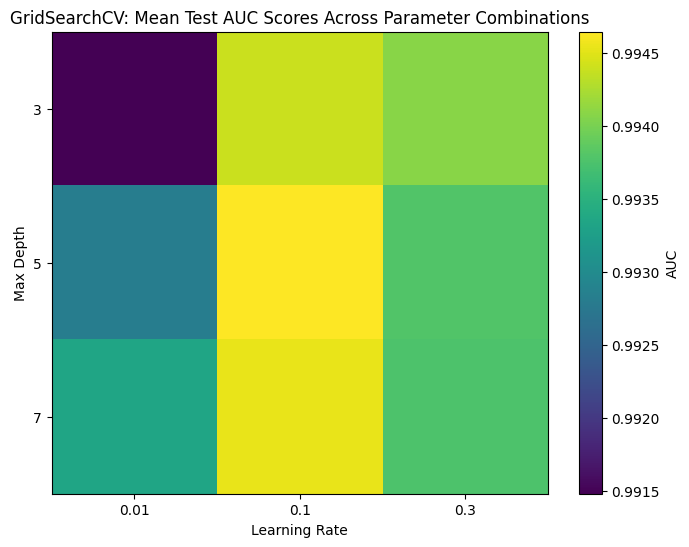

In [32]:

# Access the cv_results_ from GridSearchCV
cv_results = grid_search.cv_results_

# Convert cv_results to a DataFrame for better readability
results_df = pd.DataFrame(cv_results)

# Display the columns to understand the structure of cv_results
print(results_df.columns)

# Display the mean and std test scores for each parameter setting
summary_df = results_df[['param_max_depth', 'param_learning_rate', 'mean_test_score', 'std_test_score']]
print("Summary of Grid Search Results:")
print(summary_df)

# Optional: To analyze the performance of each fold for a specific parameter combination:
# For example, analyzing the folds for the combination of 'max_depth' = 5 and 'learning_rate' = 0.1
fold_scores = results_df[(results_df['param_max_depth'] == 5) & (results_df['param_learning_rate'] == 0.1)]
print("Fold-wise scores for max_depth=5, learning_rate=0.1:")
print(fold_scores[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']])

# You can also summarize the performance of all folds for each parameter combination
# Create a plot of the mean test score for different parameter combinations
import matplotlib.pyplot as plt

# Pivot the DataFrame to have parameter combinations on the x-axis and AUC scores on the y-axis
pivot_df = results_df.pivot_table(index='param_max_depth', columns='param_learning_rate', values='mean_test_score')

# Plot the heatmap of mean test scores across parameter combinations
plt.figure(figsize=(8, 6))
plt.title('GridSearchCV: Mean Test AUC Scores Across Parameter Combinations')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.imshow(pivot_df, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='AUC')
plt.xticks(ticks=range(len(pivot_df.columns)), labels=pivot_df.columns)
plt.yticks(ticks=range(len(pivot_df.index)), labels=pivot_df.index)
plt.show()


C:\Users\demen.SNEAKBOI\PycharmProjects\FinalProject_CAP5610\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\demen.SNEAKBOI\PycharmProjects\FinalProject_CAP5610\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\demen.SNEAKBOI\PycharmProjects\FinalProject_CAP5610\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

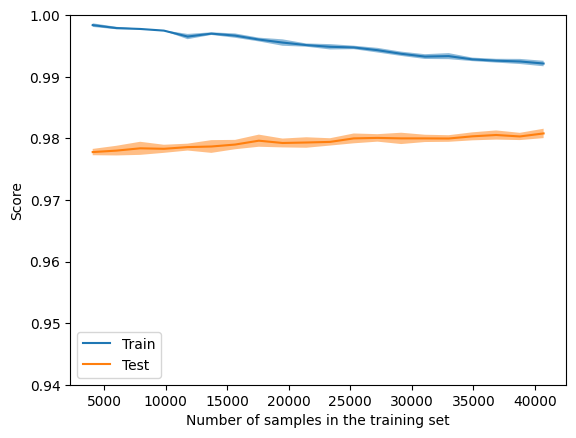

In [34]:
yebest_model = grid_search.best_estimator_
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 20)
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=val_scores, score_name="Score")
display.plot()
plt.ylim(0.94, 1)  # Set the y-axis limits from 0 to 1
plt.show()



In [10]:
best_model.fit(X_train, y_train) 
y_test_pred = best_model.predict(X_test) 
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

C:\Users\demen.SNEAKBOI\PycharmProjects\FinalProject_CAP5610\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
test_accuracy = accuracy_score(y_test, y_test_pred) 
test_precision = precision_score(y_test, y_test_pred) 
test_recall = recall_score(y_test, y_test_pred) 
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba) 
conf_matrix = confusion_matrix(y_test, y_test_pred) 
print(f"Test Accuracy: {test_accuracy:.2f}") 
print(f"Test Precision: {test_precision:.2f}") 
print(f"Test Recall: {test_recall:.2f}")
print(f"Test f1-score: {test_f1:.2f}")
print(f"Test ROC AUC: {test_roc_auc:.2f}") 
print("Confusion Matrix:") 
print(conf_matrix)

Test Accuracy: 0.98
Test Precision: 0.99
Test Recall: 0.98
Test f1-score: 0.99
Test ROC AUC: 0.99
Confusion Matrix:
[[2456   90]
 [ 192 9981]]


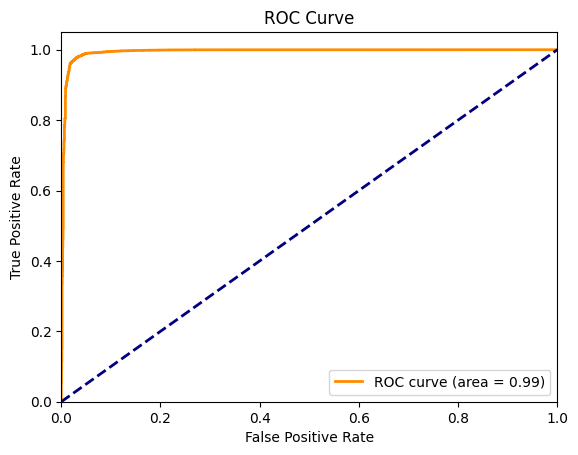

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba) 
plt.figure() 
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()

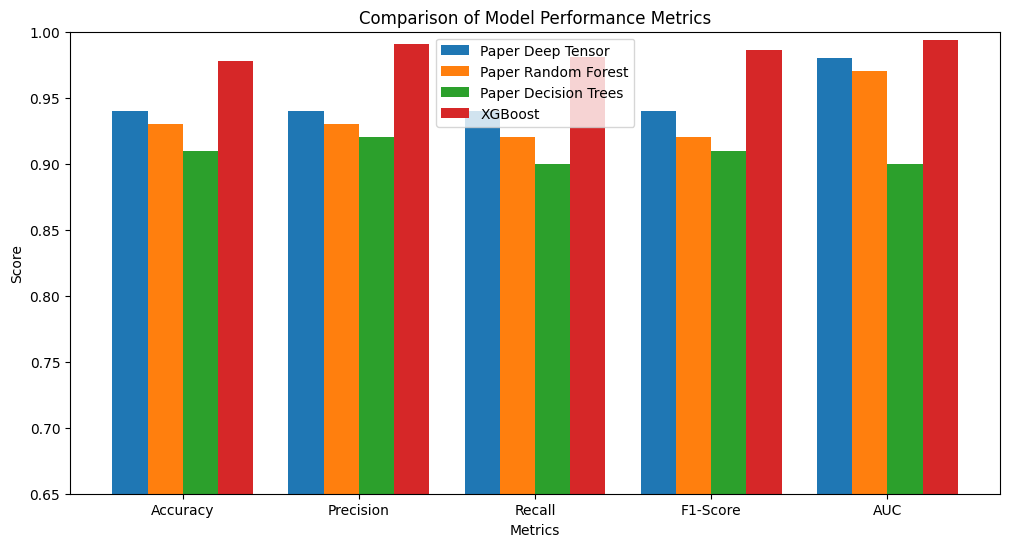

In [39]:
metrics_data = {
    'Deep Tensor': {
        'Accuracy': 0.94,
        'Precision': 0.94,
        'Recall': 0.94,
        'F1-Score': 0.94,
        'AUC': 0.98
    },
    'Random Forest': {
        'Accuracy': 0.93,
        'Precision': 0.93,
        'Recall': 0.92,
        'F1-Score': 0.92,
        'AUC': 0.97
    },
    'Decision Trees': {
        'Accuracy': 0.91,
        'Precision': 0.92,
        'Recall': 0.90,
        'F1-Score': 0.91,
        'AUC': 0.90
    }
}
your_metrics = {
    'Accuracy': test_accuracy,     # Example: replace with your model's Accuracy
    'Precision': test_precision,    # Example: replace with your model's Precision
    'Recall': test_recall,       # Example: replace with your model's Recall
    'F1-Score': test_f1,     # Example: replace with your model's F1-Score
    'AUC': test_roc_auc           # Example: replace with your model's AUC
}

# Plot the bar graph to compare hardcoded metrics with your model's metrics
methods = ['Deep Tensor', 'Random Forest', 'Decision Trees']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

deep_tensor_metrics = [metrics_data['Deep Tensor'][metric] for metric in metrics]
random_forest_metrics = [metrics_data['Random Forest'][metric] for metric in metrics]
decision_trees_metrics = [metrics_data['Decision Trees'][metric] for metric in metrics]
your_metrics_values = [your_metrics[metric] for metric in metrics]


x = range(len(metrics))

# Plotting the values for each method
plt.figure(figsize=(12, 6))

plt.bar(x, deep_tensor_metrics, width=0.2, label='Paper Deep Tensor', align='center')
plt.bar([i + 0.2 for i in x], random_forest_metrics, width=0.2, label='Paper Random Forest', align='center')
plt.bar([i + 0.4 for i in x], decision_trees_metrics, width=0.2, label='Paper Decision Trees', align='center')
plt.bar([i + 0.6 for i in x], your_metrics_values, width=0.2, label='XGBoost', align='center')

# Customize the plot
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Model Performance Metrics')
plt.xticks([i + 0.3 for i in x], metrics)  # Adjust the position of x-ticks
plt.ylim(0.65, 1)  # Set y-axis limit from 0 to 1
plt.legend()

# Show the plot
plt.show()

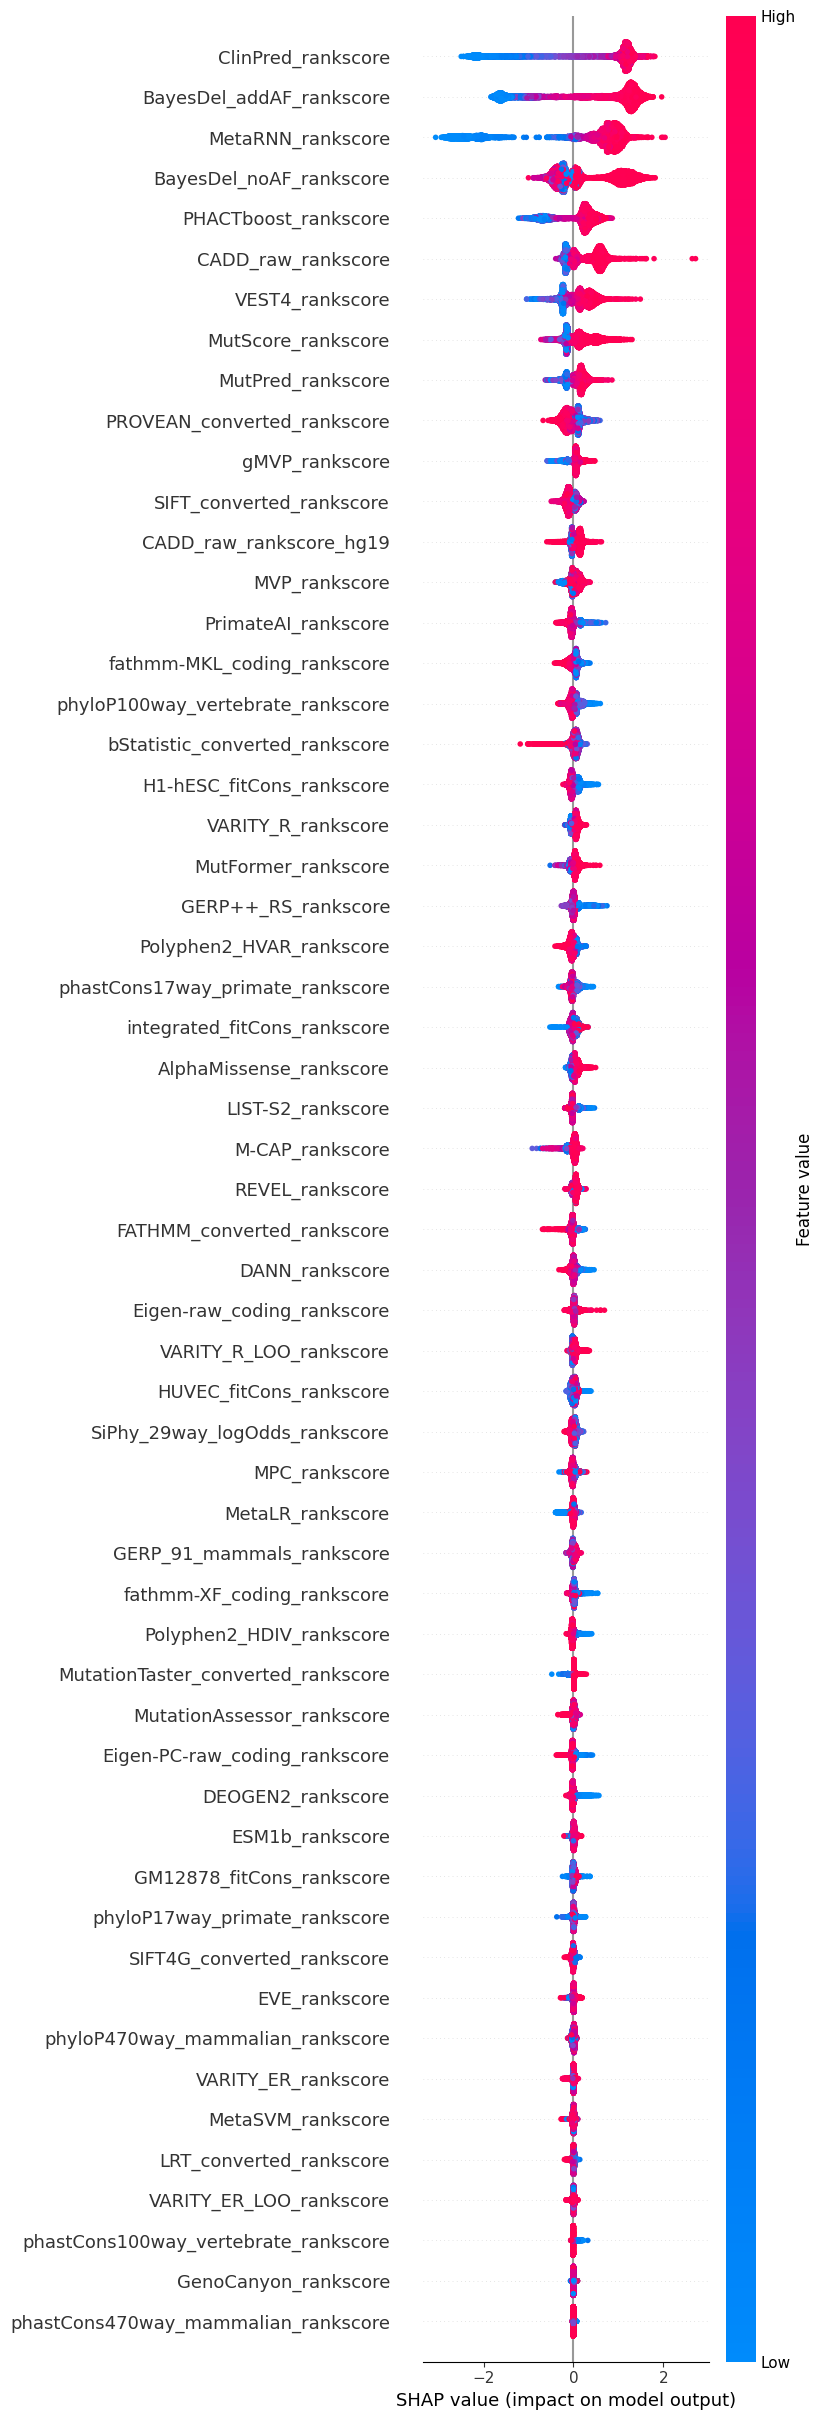

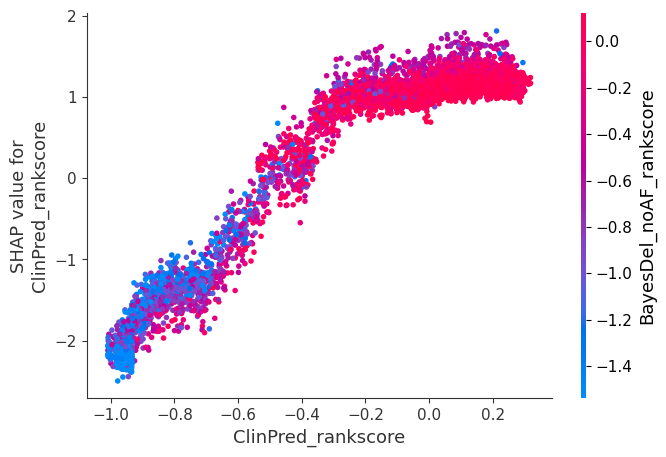

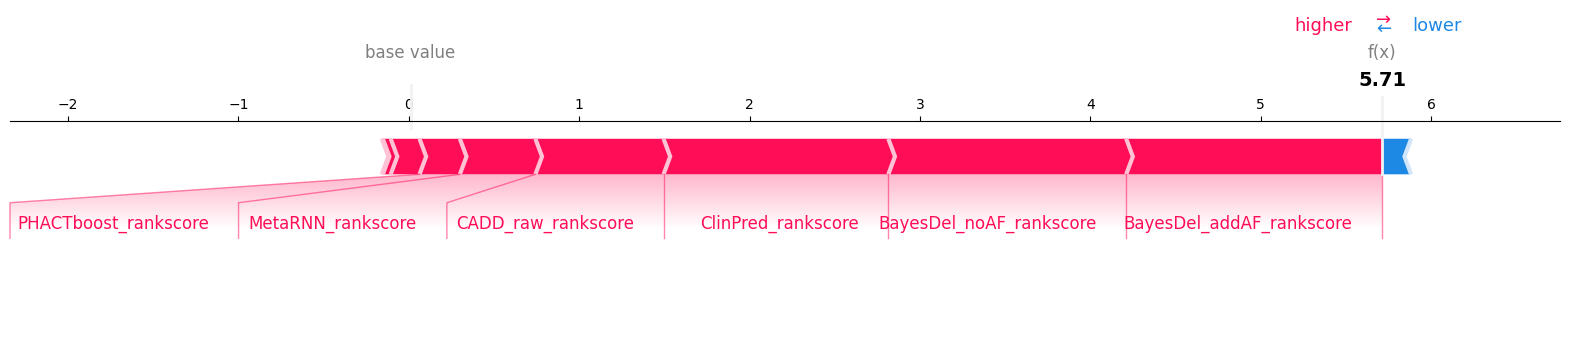

In [13]:
explainer = shap.TreeExplainer(best_model) 
shap_values = explainer.shap_values(X_test) 
selected_features = ['ClinPred_rankscore', 'BayesDel_addAF_rankscore', 'MetaRNN_rankscore','BayesDel_noAF_rankscore', 'PHACTboost_rankscore', 'CADD_raw_rankscore', 'VEST4_rankscore',
 'MutScore_rankscore', 'PROVEAN_converted_rankscore', 'SIFT_converted_rankscore'] # Get the indices of the selected features
selected_indices = [X_test.columns.get_loc(feature) for feature in selected_features]
selected_shap_values = shap_values[0, selected_indices] 
selected_feature_names = X_test.columns[selected_indices]
shap.summary_plot(shap_values, X_test, max_display=len(X_test.columns))
shap.dependence_plot("ClinPred_rankscore", shap_values, X_test)
shap.force_plot(explainer.expected_value, selected_shap_values, selected_feature_names, matplotlib=True)



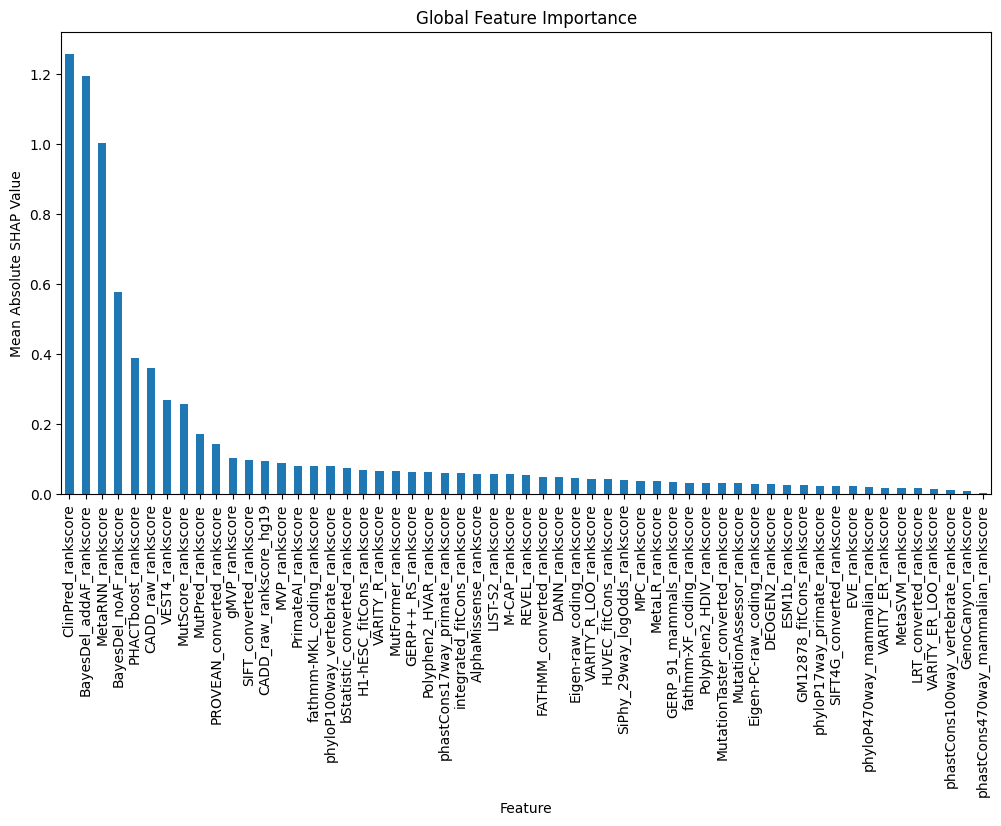

In [40]:
shap_values_abs = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame(shap_values_abs, index=X_test.columns, columns=["Mean Absolute SHAP Value"])
feature_importance = feature_importance.sort_values(by="Mean Absolute SHAP Value", ascending=False)

# Plot bar chart of feature importance
feature_importance.plot(kind="bar", figsize=(12, 6), legend=False)
plt.title("Global Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Mean Absolute SHAP Value")
plt.show()